In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Selecting qubits and calibrating circuits for an experiment

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/advanced_calibration"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/google/advanced_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/google/advanced_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/advanced_calibration.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to select good qubits and calibrate circuits for an experiment. The high-level steps are:

1. Using the latest calibration data, identify and select a good set of qubits.
2. Run a Loschmidt echo benchmark with and without calibration.
3. Apply corrections to your circuit from the calibration which performs best on the Loschmidt echo benchmark.

These steps are recommended as a minimum procedure for running on the [Quantum Computing Service (QCS)](https://quantumai.google/cirq/google/concepts). Additional steps to mitigating errors, perhaps specific to your experiment, can be added on top of this workflow.

Disclaimer: The data shown in this tutorial is exemplary and not representative of the QCS in production.

## Setup

In [3]:
try:
    import cirq
except ImportError:
    !pip install cirq --quiet

In [4]:
# The Google Cloud Project id to use.
project_id = 'rlarose-quantum' #@param {type:"string"}

if project_id == '':
    import os 
    if 'GOOGLE_CLOUD_PROJECT' not in os.environ:
        raise Exception("Please setup project_id in this cell or set the `GOOGLE_CLOUD_PROJECT` env var to your project id.")
    project_id = os.environ['GOOGLE_CLOUD_PROJECT']
else: 
    import os
    os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

def authenticate_user():
    """Runs the user through the Colab OAuth process.

    Checks for Google Application Default Credentials and runs interactive login 
    if the notebook is executed in Colab. In case the notebook is executed in Jupyter notebook
    or other IPython runtimes, no interactive login is provided, it is assumed that the 
    `GOOGLE_APPLICATION_CREDENTIALS` env var is set or `gcloud auth application-default login`
    was executed already.

    For more information on using Application Default Credentials see 
    https://cloud.google.com/docs/authentication/production
    """
    in_colab = False
    try:
        from IPython import get_ipython
        in_colab = 'google.colab' in str(get_ipython())
    except: 
        # Notebook is not executed within IPython. Assuming external authentication.
        return 

    if in_colab: 
        from google.colab import auth      
        print("Getting OAuth2 credentials.")
        print("Press enter after entering the verification code.")
        auth.authenticate_user(clear_output=False)
        print("Authentication complete.")
    else: 
        print("Notebook is not executed with Colab, assuming Application Default Credentials are set up.") 

authenticate_user()

print("Successful authentication to Google Cloud.")

Getting OAuth2 credentials.
Press enter after entering the verification code.
Authentication complete.
Successful authentication to Google Cloud.


In [5]:
import cirq
from cirq.experiments import random_quantum_circuit_generation as rqcg
import cirq_google as cg

import matplotlib.pyplot as plt
import numpy as np

In [6]:
#@title Helper functions
from typing import Optional, Sequence


def create_xeb_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.FSimGate(np.pi / 4, 0.0),
    seed: Optional[int] = None,
) -> cirq.Circuit:
    return rqcg.random_rotations_between_grid_interaction_layers_circuit(
        qubits, 
        depth=cycles,
        two_qubit_op_factory=lambda a, b, _: twoq_gate.on(a, b),
        pattern=cirq.experiments.GRID_STAGGERED_PATTERN,
        single_qubit_gates=[cirq.PhasedXPowGate(phase_exponent=p, exponent=0.5)
                            for p in np.arange(-1.0, 1.0, 0.25)],
        seed=seed
    )



def create_loschmidt_echo_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.FSimGate(np.pi / 4, 0.0),
    seed: Optional[int] = None,
) -> cirq.Circuit:
    """Returns a Loschmidt echo circuit using a random unitary U.

    Args:
        qubits: Qubits to use.
        cycles: Depth of random rotations in the forward & reverse unitary.
        twoq_gate: Two-qubit gate to use.
        pause: Optional duration to pause for between U and U^\dagger.
        seed: Seed for circuit generation.
    """
    forward = create_xeb_circuit(qubits, cycles, twoq_gate, seed)
    return forward + cirq.inverse(forward) + cirq.measure(*qubits, key="z")



def to_ground_state_prob(result: cirq.Result) -> float:
    return np.mean(np.sum(result.measurements["z"], axis=1) == 0)

## Select qubits

Below, select a processor and (comma-separated list of) calibration metric(s) to visualize the latest calibration report.

Note: All calibration metrics are defined in [this guide](https://quantumai.google/cirq/google/calibration). If you are unsure which metric to focus on for your experiment, we recommend `parallel_p00_error` and/or `parallel_p11_error` to eliminate qubits with high readout errors.

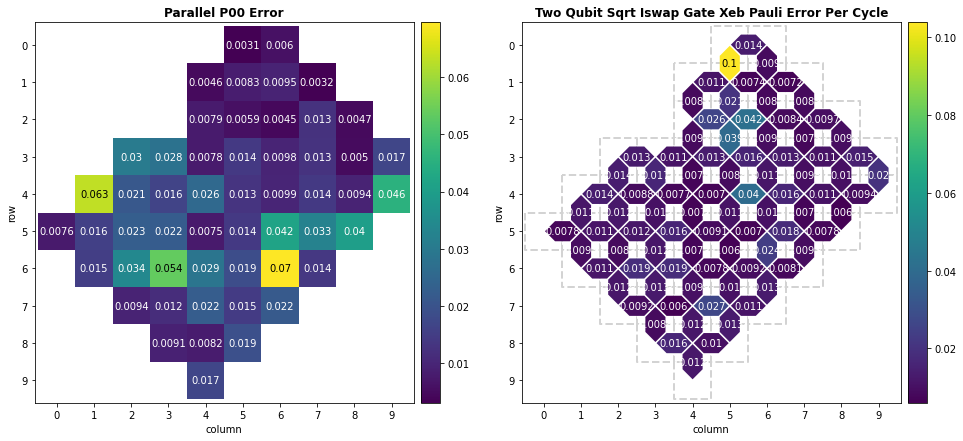

In [7]:
processor_id = "weber" #@param {type:"string"}
metrics = "parallel_p00_error, two_qubit_sqrt_iswap_gate_xeb_pauli_error_per_cycle" #@param {type:"string"}
metrics = [m.strip() for m in metrics.split(sep=",")]

_, axes = plt.subplots(
    nrows=1, ncols=len(metrics), figsize=(min(16, 8 * len(metrics)), 7)
)

calibration = cg.get_engine_calibration(processor_id=processor_id)
for i, metric in enumerate(metrics):
    calibration.heatmap(metric).plot(ax=axes[i] if len(metrics) > 1 else axes);

Using this report as a guide, select a set of qubits.

In [8]:
# Select qubit indices here.
qubit_indices = [
    (2, 5), (2, 6), (2, 7), (2, 8), (3, 8), 
    (3, 7), (3, 6), (3, 5), (4, 5), (4, 6)  
]
qubits = [cirq.GridQubit(*idx) for idx in qubit_indices]

### Floquet calibration setup

Note: See the [Floquet calibration tutorial](https://quantumai.google/cirq/tutorials/google/floquet) for background about this method.

Specify the parameters of the `cirq.FSimGate` to characterize with Floquet calibration below.

In [9]:
floquet_options = cg.FloquetPhasedFSimCalibrationOptions(
    characterize_theta=False,
    characterize_zeta=True,
    characterize_chi=False,
    characterize_gamma=True,
    characterize_phi=False,
)

### XEB calibration setup

Note: See the [XEB theory tutorial](https://quantumai.google/cirq/qcvv/xeb_theory) for background about this method.

Specify the cycle depths and other options for XEB calibration below. Note that all `cirq.FSimGate` parameters are characterized by default.

In [10]:
xeb_options = cg.LocalXEBPhasedFSimCalibrationOptions(
    cycle_depths=(5, 25, 50, 100),
    n_processes=1,
    fsim_options=cirq.experiments.XEBPhasedFSimCharacterizationOptions(
        characterize_theta=False,
        characterize_zeta=True,
        characterize_chi=True,
        characterize_gamma=True,
        characterize_phi=False,
    ),
)

## Run and benchmark calibrations

Run the next cell to create a batch of circuits for a Loschmidt echo benchmark. This benchmark is used to compare calibrations. 

Note: See the [Loschmidt echo tutorial](https://quantumai.google/cirq/tutorials/google/echoes) for background about this benchmark.

In [11]:
"""Setup the Loschmidt echo experiment."""
cycle_values = range(0, 40 + 1, 4)
nreps = 20_000
trials = 10

loschmidt_echo_batch = [
    create_loschmidt_echo_circuit(qubits, cycles=c, seed=trial)
    for trial in range(trials) for c in cycle_values
]

sampler = cg.get_engine_sampler(
    project_id=project_id,
    processor_id=processor_id,
    gate_set_name="sqrt_iswap",
)

Now, execute the next cell to run the benchmark with and without each calibration.

Note: You can comment or remove an item from `calibrations` to skip that calibration.

In [12]:
"""Run a Loschmidt echo with no / Floquet / XEB calibration."""
calibrations = {
    "No calibration": None,
    "Floquet calibration": floquet_options,
    "XEB calibration": xeb_options,
}

all_probs = []
for options in calibrations.values():
    if options is None:
        batch = loschmidt_echo_batch
    else:
        # Get moments to characterize from the batch.
        characterization_requests = cg.prepare_characterization_for_operations(
            loschmidt_echo_batch, options
        )

        # Characterize the moments.
        characterizations = cg.run_calibrations(characterization_requests, sampler)

        # TODO: Remove after https://github.com/quantumlib/Cirq/pull/4118.
        batch_to_compensate = [
            cg.prepare_characterization_for_moments(circuit, options)[0] 
            for circuit in loschmidt_echo_batch
        ]

        # Compensate each circuit in the batch.
        batch = [
            cg.make_zeta_chi_gamma_compensation_for_moments(circ, characterizations).circuit 
            for circ in batch_to_compensate
        ]

    # Run the batch.
    results = sampler.run_batch(programs=batch, repetitions=nreps)

    # Compute survival probabilities.
    probs = [to_ground_state_prob(*res) for res in results]
    all_probs.append(np.array(probs).reshape(trials, len(cycle_values)))

100%|██████████| 45/45 [03:56<00:00,  5.24s/it]


The next cell plots the results.

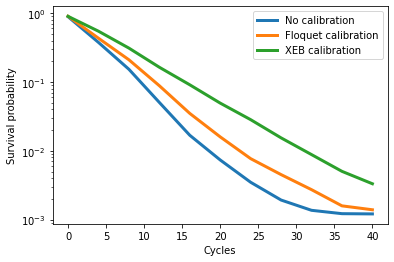

In [13]:
for probs, label in zip(all_probs, calibrations.keys()):
    plt.semilogy(cycle_values, np.average(probs, axis=0), lw=3, label=label)

plt.xlabel("Cycles")
plt.ylabel("Survival probability")
plt.legend();

## Apply corrections to your circuit

In the next cell, define the quantum circuit(s) for your experiment.

In [14]:
"""Define the quantum circuit(s) for your experiment here."""
circuit = create_xeb_circuit(qubits, cycles=10)

Now, use the calibration which gives the best results on the Loschmidt echo benchmark.

In [15]:
circuit_with_characterizations, characterization_requests = \
    cg.prepare_characterization_for_moments(
        circuit,
        xeb_options,  # <- Pick Floquet or XEB options here.
    )

# Characterize the moments.
characterizations = cg.run_calibrations(characterization_requests, sampler)

# Apply corrections.
calibrated_circuit = cg.make_zeta_chi_gamma_compensation_for_moments(
    circuit_with_characterizations,
    characterizations,
)
print("Calibrated circuit:\n")
calibrated_circuit.circuit

100%|██████████| 45/45 [03:08<00:00,  4.19s/it]


Calibrated circuit:



┌──────────────────────────────────────────┐                                                ┌────────────────────────────┐                                                                                                                                                                                                                                                                                                        ┌──────────────────────────────────────────┐                                                ┌────────────────────────────┐                                                ┌──────────────────────────────────────────┐                                                ┌────────────────────────────┐
(2, 5): ───PhX(-0.5)^0.5───────────────────────────────────────────────────────────────────────────────PhX(1)^0.5───────Rz(0.006π)─────FSim(0.25π, 0)──────────────────Rz(0.041π)────PhX(0)^0.5───────Rz(0.018π)────FSim(0.25π, 0)───Rz(0.071π)────PhX(1)^0.5────────────────────────────────────────────────────PhX(0.75)^0.5────Rz(0.018π)────FSim(0.25π, 0)───Rz(0.071π)────PhX(1)^0.5────────────────────────────────────────────────────PhX(-0.75)^0.5──────────────────────────────────────────────────────────────────────────────PhX(-0.5)^0.5────Rz(0.006π)─────FSim(0.25π, 0)──────────────────Rz(0.041π)────PhX(0.25)^0.5───────────────────────────────────────────────────────────────────────────────PhX(-0.25)^0.5───Rz(0.006π)─────FSim(0.25π, 0)──────────────────Rz(0.041π)────PhX(0.25)^0.5────
                                                                                                                                       │                                                                            │                                                                                                                           │                                                                                                                                                                                                                        │                                                                                                                                                                         │
(2, 6): ───PhX(-0.75)^0.5───Rz(0.025π)─────FSim(0.25π, 0)────────────────────────────────Rz(0.048π)────PhX(-0.25)^0.5──────────────────┼─────────────────────────────────────────────PhX(0.5)^0.5─────Rz(0.003π)────FSim(0.25π, 0)───Rz(-0.05π)────PhX(0)^0.5───────Rz(0.022π)────FSim(0.25π, 0)───Rz(0.02π)─────PhX(-0.5)^0.5────Rz(0.003π)────FSim(0.25π, 0)───Rz(-0.05π)────PhX(0)^0.5───────Rz(0.022π)────FSim(0.25π, 0)───Rz(0.02π)─────PhX(-0.5)^0.5────Rz(0.025π)─────FSim(0.25π, 0)────────────────────────────────Rz(0.048π)────PhX(1)^0.5──────────────────────┼─────────────────────────────────────────────PhX(-0.5)^0.5────Rz(0.025π)─────FSim(0.25π, 0)────────────────────────────────Rz(0.048π)────PhX(1)^0.5──────────────────────┼─────────────────────────────────────────────PhX(-0.75)^0.5───
                                           │                                                                                           │                                                                                                                                          │                                                                                                                           │                                                              │                                                                                           │                                                                             │                                                                                           │
(2, 7): ───PhX(-0.75)^0.5──────────────────┼───────────────────────────────────────────────────────────PhX(0.75)^0.5────Rz(0.022π)─────┼─────────────FSim(0.25π, 0)────Rz(0.025π)────PhX(-0.25)^0.5───Rz(0.018π)────FSim(0.25π, 0)───Rz(0.008π)────PhX(0)^0.5───────Rz(0)

Note: The corrections to the circuit are `cirq.Rz` gates padding the $\sqrt{\text{iSWAP}}$ gates.

You can now run this calibrated circuit on the Quantum Computing Service.